In [59]:
# %pip install wordcloud
# %pip install ace_tools

# NYT Restaurant Reviews Bias Analysis
This notebook contains the code for the NLP analyses, including sentiment analysis, lexical analysis, CriticsPick trends, and topic modeling.

In [60]:

# Import necessary libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
# import ace_tools as tools

# Load dataset
data_path = '/Users/skareti/Desktop/Independent Study/NYTRestaurantReviews/data/modeling_dfv2.csv'
df = pd.read_csv(data_path, index_col = 0)

# Initial exploration
df.head()
    

,Restaurant_name,Author,Publishing_Date,Rating,Price,Cuisine,Neighborhood,CriticsPick,Description,Rank,...,Asian-Pacific,Other Languages,Total 25+,Bachelor,Master,Professional,College Graduates (%),Most Common Language (Other than English),Income_Group,College_Graduates_Group
0,'Wichcraft,PETER MEEHAN,"Sept. 7, 2005",NaN,$,Cuisine_Other,Midtown South,0,The sandwiches are good at this Tom Colicchio-...,0.0,...,1060.0,871.0,43500.0,18102.0,10877.0,4803.0,0.776598,Spanish,Medium,High
1,12 Chairs,ERIC ASIMOV,"Oct. 18, 1996",NaN,$$,Cuisine_Other,SoHo,0,"It offers Middle Eastern dishes, American sand...",0.0,...,367.0,450.0,16809.0,8292.0,3089.0,1217.0,0.749479,Spanish,Medium,Medium
2,15 East,FRANK BRUNI,"July 11, 2007",2 star,$$$$,Japanese,Union Square,0,15 East stands out in a crowded marketplace of...,0.0,...,789.0,1757.0,37093.0,16265.0,7846.0,3915.0,0.755560,Spanish,High,Medium
3,188 Bakery Cuchifritos,PETE WELLS,"April 2, 2024",NaN,$,Cuisine_Other,Fordham Heights,0,NaN,86.0,...,27927.0,773.0,52353.0,5028.0,2119.0,587.0,0.147728,Spanish,Low,Very Low
4,2nd City,LIGAYA MISHAN,"Sept. 15, 2016",NaN,$$,Philippine,West Village,0,"At this Filipino-leaning taqueria, the chef Jo...",0.0,...,177.0,726.0,25527.0,12251.0,6490.0,1836.0,0.806088,Spanish,Medium,High


## Sentiment Analysis

In [61]:
# Define the updated list of wealthy neighborhoods
wealthy_neighborhoods = [
    'Hudson Yards', 'SoHo', 'TriBeCa', 'Hudson Square', 'Little Italy', 'Chinatown', 
    'Cobble Hill', 'Carroll Gardens', 'Flatiron District', 'West Village', 'Chelsea', 
    'Downtown Brooklyn', 'Greenwood Heights', 'DUMBO', 'Boerum Hill', 'Williamsburg', 
    'Brooklyn Heights', 'Prospect Heights', 'Gowanus', 'Battery Park City', 'Upper East Side', 
    'Greenpoint', 'Upper West Side', 'Park Slope', 'Theatre District - Times Square', 'Central Midtown',
    'Windsor Terrace', 'Hunters Point', 'Gramercy Park', 'Greenwich Village', 'Dyker Heights',
    'Financial District', 'Belle Harbor', 'Lower East Side', 'Hollis Hills', 'Prospect - Lefferts Gardens',
    'Madison', 'Little Neck', 'Clinton - Hell\'s Kitchen', 'Auburndale', 'Fresh Meadows', 
    'Queensboro Hill', 'Crown Heights', 'Mill Basin', 'Ditmars - Steinway', 'East Village', 
    'Borough Park', 'Fieldston', 'Clinton Hill', 'Rockwood Park', 'Sutton Place', 'Fort Greene', 'NoMad', 
    'Nolita', 'Flatiron', 'Flatiron district','Midtown','Midtown East', 'NoLIta', 'Clinton', 'Dumbo', 
    'Koreatown', 'Midtown West', 'Times Square Theatre District', 'Union Square'
]

# Update the Wealthy_Neighborhood indicator
df['Wealthy_Neighborhood'] = df['Neighborhood'].isin(wealthy_neighborhoods).astype(int)



In [62]:

# Sentiment Analysis: Calculate polarity and subjectivity
df['Sentiment_Polarity'] = df['Description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['Sentiment_Subjectivity'] = df['Description'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Group by wealth indicator
wealth_text_analysis = df.groupby('Wealthy_Neighborhood')[
    ['Sentiment_Polarity', 'Sentiment_Subjectivity']
].mean()
wealth_text_analysis
    

,Sentiment_Polarity,Sentiment_Subjectivity
Wealthy_Neighborhood,,
0,0.134897,0.41374
1,0.142172,0.41999


### Cuisine Analysis

In [63]:
# Define broader cuisine categories
cuisine_categories = {
    'European': ['French', 'Italian', 'Mediterranean', 'Eastern European', 'Spanish', 'Greek'],
    'Asian': ['Chinese', 'Japanese', 'Korean', 'Indian', 'Thai', 'Vietnamese', 'Filipino'],
    'American': ['American', 'Southern', 'BBQ', 'Steakhouse', 'New American'],
    'Latin American': ['Mexican', 'Latin American', 'Caribbean', 'Brazilian', 'Peruvian'],
    'Middle Eastern': ['Middle Eastern', 'Israeli', 'Lebanese', 'Turkish'],
    'African': ['Ethiopian', 'Moroccan', 'Nigerian'],
    'Other': ['Vegetarian', 'Vegan', 'Fusion', 'Seafood', 'Pizza', 'Sandwiches']
}

# Map cuisines in the dataset to broader categories
def map_cuisine(cuisine, categories):
    for category, keywords in categories.items():
        if any(keyword in str(cuisine) for keyword in keywords):
            return category
    return 'Other'

df['Cuisine_Category'] = df['Cuisine'].apply(lambda x: map_cuisine(x, cuisine_categories))

# Analyze cuisine distribution by Wealthy_Neighborhood
cuisine_distribution = df.groupby(['Wealthy_Neighborhood', 'Cuisine_Category']).size().unstack(fill_value=0)

# Analyze sentiment polarity by cuisine category
sentiment_by_cuisine = df.groupby('Cuisine_Category')[
    ['Sentiment_Polarity', 'Sentiment_Subjectivity']
].mean()



cuisine_distribution, sentiment_by_cuisine


(Cuisine_Category      American  Asian  European  Latin American  \
 Wealthy_Neighborhood                                              
 0                           44     81        30              27   
 1                          118    185       198              34   
 
 Cuisine_Category      Middle Eastern  Other  
 Wealthy_Neighborhood                         
 0                                 18    165  
 1                                 22    320  ,
                   Sentiment_Polarity  Sentiment_Subjectivity
 Cuisine_Category                                            
 American                    0.125117                0.412149
 Asian                       0.129728                0.429635
 European                    0.145674                0.439160
 Latin American              0.206468                0.387462
 Middle Eastern              0.123382                0.415486
 Other                       0.141036                0.408068)

## Temporal Analysis

In [64]:
# Analyze CriticsPick status by Cuisine Category
critics_pick_cuisine = df.groupby(['Cuisine_Category', 'CriticsPick']).size().unstack(fill_value=0)

# Calculate proportions of CriticsPick within each cuisine category
critics_pick_cuisine['Proportion_CriticsPick'] = (
    critics_pick_cuisine[1] / (critics_pick_cuisine[0] + critics_pick_cuisine[1])
)

# Analyze temporal trends in cuisine preferences using publishing dates
df['Publishing_Year'] = pd.to_datetime(df['Publishing_Date'], errors='coerce').dt.year
cuisine_trends = df.groupby(['Publishing_Year', 'Cuisine_Category']).size().unstack(fill_value=0)


critics_pick_cuisine, cuisine_trends


(CriticsPick         0    1  Proportion_CriticsPick
 Cuisine_Category                                  
 American          117   45                0.277778
 Asian             162  104                0.390977
 European          151   77                0.337719
 Latin American     39   22                0.360656
 Middle Eastern     22   18                0.450000
 Other             338  147                0.303093,
 Cuisine_Category  American  Asian  European  Latin American  Middle Eastern  \
 Publishing_Year                                                               
 1983                     0      1         0               0               0   
 1984                     0      0         1               0               0   
 1985                     0      0         1               0               0   
 1986                     1      0         0               0               0   
 1987                     1      0         0               0               0   
 1989                  

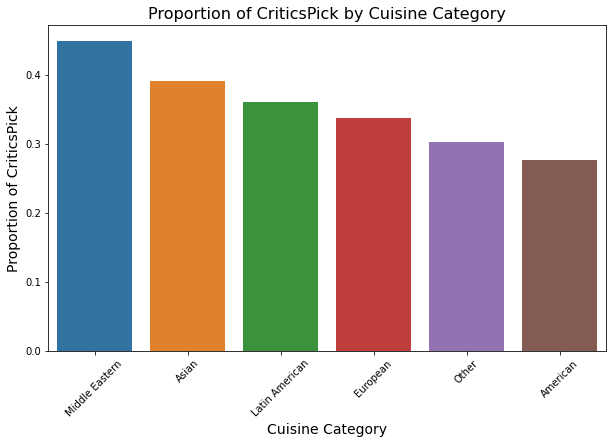

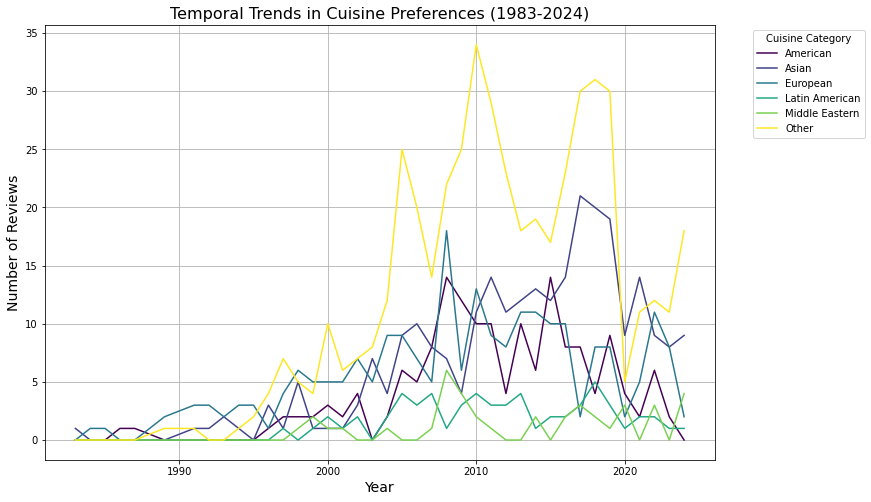

In [65]:
# Create visualizations to illustrate findings

import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Proportion of CriticsPick by Cuisine Category
critics_pick_cuisine.sort_values('Proportion_CriticsPick', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=critics_pick_cuisine.index, y='Proportion_CriticsPick', data=critics_pick_cuisine)
plt.title('Proportion of CriticsPick by Cuisine Category', fontsize=16)
plt.xlabel('Cuisine Category', fontsize=14)
plt.ylabel('Proportion of CriticsPick', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Visualization 2: Temporal Trends in Cuisine Preferences
cuisine_trends.plot(figsize=(12, 8), colormap='viridis')
plt.title('Temporal Trends in Cuisine Preferences (1983-2024)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.legend(title='Cuisine Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True)
plt.show()


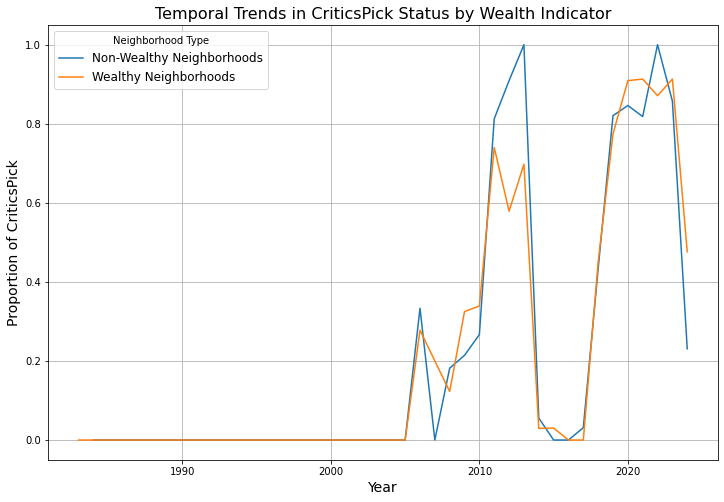

CriticsPick                            0   1  Proportion_CriticsPick
Publishing_Year Wealthy_Neighborhood                                
1983            1                      1   0                0.000000
1984            0                      1   0                0.000000
1985            1                      1   0                0.000000
1986            1                      1   0                0.000000
1987            1                      1   0                0.000000
...                                   ..  ..                     ...
2022            1                      4  27                0.870968
2023            0                      1   6                0.857143
                1                      2  21                0.913043
2024            0                     10   3                0.230769
                1                     11  10                0.476190

[70 rows x 3 columns]

In [66]:
# Analyze CriticsPick patterns by year and Wealthy_Neighborhood
critics_pick_trends = df.groupby(['Publishing_Year', 'Wealthy_Neighborhood', 'CriticsPick']).size().unstack(fill_value=0)

# Calculate proportions of CriticsPick status within wealthy and non-wealthy neighborhoods over time
critics_pick_trends['Proportion_CriticsPick'] = (
    critics_pick_trends[1] / (critics_pick_trends[0] + critics_pick_trends[1])
)

# Generate a temporal visualization for CriticsPick trends
plt.figure(figsize=(12, 8))
for neighborhood in [0, 1]:
    subset = critics_pick_trends[critics_pick_trends.index.get_level_values(1) == neighborhood]
    plt.plot(subset.index.get_level_values(0), subset['Proportion_CriticsPick'], 
             label=f"{'Wealthy' if neighborhood == 1 else 'Non-Wealthy'} Neighborhoods")

plt.title("Temporal Trends in CriticsPick Status by Wealth Indicator", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Proportion of CriticsPick", fontsize=14)
plt.legend(title="Neighborhood Type", fontsize=12)
plt.grid(True)
plt.show()

# Display CriticsPick trends to the user for inspection
# tools.display_dataframe_to_user(name="CriticsPick Temporal Trends by Wealth Indicator", dataframe=critics_pick_trends)

critics_pick_trends


## Lexical Analysis

In [67]:
# Add a column with the word count for each description
df['Description_WordCount'] = df['Description'].fillna('').apply(lambda x: len(x.split()))

# Recalculate missing descriptions and word count statistics
missing_descriptions = df['Description'].isnull().sum()
word_count_stats = df['Description_WordCount'].describe()

missing_descriptions, word_count_stats

data_cleaned = df.dropna(subset=['Description'])

print(data_cleaned.shape)

custom_stop_words = set([
    'the', 'and', 'to', 'of', 'in', 'a', 'is', 'it', 'with', 'on', 'for', 'as',
    'at', 'this', 'that', 'but', 'by', 'an', 'or', 'are', 'be', 'was', 'were',
    'has', 'have', 'from', 'not', 'they', 'will', 'can', 'would', 'should',
    'also', 'about', 'if', 'one', 'all', 'which', 'we', 'their', 'more', 'no',
    'so', 'you', 'do', 'some', 'been', 'when', 'who', 'where', 'its', 'than'
])



# Function to generate frequent words for a specific group
def get_frequent_words(group_data, num_words=10):
    text = ' '.join(group_data['Description'])
    cleaned_text = ''.join([char.lower() if char not in string.punctuation else ' ' for char in text])
    tokens = [word for word in cleaned_text.split() if word not in custom_stop_words]
    return Counter(tokens).most_common(num_words)

# Get frequent words for each price range
frequent_words_by_price = data_cleaned.groupby('Price').apply(get_frequent_words).to_dict()

# Get frequent words for a few selected neighborhoods (top 5 by frequency)
top_neighborhoods = data_cleaned['Neighborhood'].value_counts().head(5).index
frequent_words_by_neighborhood = data_cleaned[data_cleaned['Neighborhood'].isin(top_neighborhoods)].groupby('Neighborhood').apply(get_frequent_words).to_dict()

# tools.display_dataframe_to_user(name="Frequent Words by Price Range", dataframe=pd.DataFrame.from_dict(frequent_words_by_price, orient='index', columns=['Word', 'Frequency']))
# tools.display_dataframe_to_user(name="Frequent Words by Neighborhood", dataframe=pd.DataFrame.from_dict(frequent_words_by_neighborhood, orient='index', columns=['Word', 'Frequency']))

# Proceed with word count comparison
word_count_by_price = data_cleaned.groupby('Price')['Description_WordCount'].describe()
word_count_by_critics_pick = data_cleaned.groupby('CriticsPick')['Description_WordCount'].describe()

# tools.display_dataframe_to_user(name="Word Count Statistics by Price Range", dataframe=word_count_by_price)
# tools.display_dataframe_to_user(name="Word Count Statistics by Critics' Pick Status", dataframe=word_count_by_critics_pick)

word_count_by_price, word_count_by_critics_pick

(1221, 429)


(       count       mean        std  min   25%   50%   75%    max
 Price                                                           
 $      295.0  31.847458  18.446847  5.0  18.0  28.0  42.0  118.0
 $$     490.0  28.940816  17.271635  4.0  17.0  24.0  37.0  111.0
 $$$    281.0  27.814947  14.841830  5.0  17.0  23.0  37.0   75.0
 $$$$   153.0  31.607843  16.040342  7.0  20.0  28.0  39.0   89.0,
              count       mean        std  min   25%   50%   75%    max
 CriticsPick                                                           
 0            810.0  27.712346  16.631392  4.0  16.0  23.0  36.0  111.0
 1            411.0  33.722628  16.893958  5.0  20.5  31.0  43.5  118.0)

In [68]:
# Adjust frequent words processing for visualization
frequent_words_by_price_df = pd.DataFrame([
    {'Price': key, 'Word': word, 'Frequency': freq}
    for key, values in frequent_words_by_price.items()
    for word, freq in values
])

frequent_words_by_neighborhood_df = pd.DataFrame([
    {'Neighborhood': key, 'Word': word, 'Frequency': freq}
    for key, values in frequent_words_by_neighborhood.items()
    for word, freq in values
])

# Display results for frequent words
# tools.display_dataframe_to_user(name="Frequent Words by Price Range", dataframe=frequent_words_by_price_df)
# tools.display_dataframe_to_user(name="Frequent Words by Neighborhood", dataframe=frequent_words_by_neighborhood_df)

# Proceed with word count comparison
word_count_by_price = data_cleaned.groupby('Price')['Description_WordCount'].describe()
word_count_by_critics_pick = data_cleaned.groupby('CriticsPick')['Description_WordCount'].describe()

# tools.display_dataframe_to_user(name="Word Count Statistics by Price Range", dataframe=word_count_by_price)
# tools.display_dataframe_to_user(name="Word Count Statistics by Critics' Pick Status", dataframe=word_count_by_critics_pick)

frequent_words_by_price_df, frequent_words_by_neighborhood_df, word_count_by_price, word_count_by_critics_pick


(   Price        Word  Frequency
 0      $        food         63
 1      $  restaurant         48
 2      $         new         35
 3      $           —         33
 4      $        rice         32
 5      $      street         31
 6      $         his         27
 7      $        chef         27
 8      $        menu         27
 9      $           s         26
 10    $$  restaurant        137
 11    $$        food        106
 12    $$        menu         74
 13    $$      dishes         68
 14    $$        like         60
 15    $$        chef         60
 16    $$         new         58
 17    $$           s         57
 18    $$         his         49
 19    $$           —         44
 20   $$$  restaurant         75
 21   $$$        food         67
 22   $$$        menu         49
 23   $$$           s         46
 24   $$$         new         36
 25   $$$        chef         35
 26   $$$      dishes         33
 27   $$$        like         30
 28   $$$     cooking         28
 29   $$$ 

## Topic Modeling

In [69]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Prepare text for topic modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectors = vectorizer.fit_transform(df['Description'].dropna())

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(text_vectors)

# Extract topic words
words = vectorizer.get_feature_names_out()
topic_words = {}
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [words[i] for i in topic.argsort()[-10:][::-1]]
    topic_words[f"Topic {topic_idx + 1}"] = top_words

topic_words_df = pd.DataFrame(topic_words)
topic_words_df
    

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,restaurant,restaurant,like,food,restaurant
1,food,new,food,restaurant,new
2,chef,menu,chef,menu,york
3,dishes,like,restaurant,cooking,menu
4,new,city,cuisine,new,street
5,menu,chef,restaurants,kitchen,like
6,east,york,pizza,chef,dishes
7,serves,food,menu,good,bar
8,york,dishes,bar,cuisine,small
9,american,small,manhattan,dishes,counter


## NER

In [70]:

import spacy

# Load SpaCy's English model for NER
nlp = spacy.load("en_core_web_sm")

# Function to extract entities using SpaCy
def spacy_ner(texts):
    entities = []
    for doc in nlp.pipe(texts, disable=["parser", "tagger"]):
        entities.extend([(ent.text, ent.label_) for ent in doc.ents])
    return pd.DataFrame(entities, columns=["Entity", "Label"])

# Perform SpaCy NER on sample texts
sample_texts = df['Description'].dropna().sample(100, random_state=42)
spacy_ner_results = spacy_ner(sample_texts)

# Display the extracted entities
spacy_ner_results.head()


/Users/skareti/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,Entity,Label
0,Del Posto,PERSON
1,ValpolicellaGrassi,PRODUCT
2,Claud,PERSON
3,the East Village,LOC
4,several years,DATE


## Keyword Context Analysis

In [71]:
# Keyword and Contextual Analysis
from collections import defaultdict

# Keywords of interest
keywords = ["authentic", "refined", "modern", "traditional", "comfort", "exclusive", "vibrant"]

# Function to analyze context around keywords
def keyword_context_analysis(texts, keywords, window=5):
    keyword_contexts = defaultdict(list)
    for text in texts:
        tokens = text.split()
        for idx, token in enumerate(tokens):
            if token.lower() in keywords:
                start = max(0, idx - window)
                end = min(len(tokens), idx + window + 1)
                context = " ".join(tokens[start:end])
                keyword_contexts[token.lower()].append(context)
    return keyword_contexts

# Sample texts for keyword context analysis
sample_texts = df['Description'].dropna().sample(100, random_state=42)

# Perform the analysis
contexts = keyword_context_analysis(sample_texts, keywords)

# Create a dataframe to display contexts for each keyword
keyword_context_df = pd.DataFrame([{"Keyword": k, "Context": c} for k, contexts in contexts.items() for c in contexts])

# Display the results to the user
# tools.display_dataframe_to_user(name="Keyword Context Analysis", dataframe=keyword_context_df)

keyword_context_df.head()


,Keyword,Context
0,comfort,"Delicatessen, specializing in interpretive com..."
1,comfort,are as much theater as comfort food.
2,traditional,"says it is “not a traditional steakhouse, but ..."
3,traditional,Bati serves traditional Ethiopian food in an e...
4,traditional,she makes daily specials with traditional herb...


## Adjectives

In [75]:
# Ensure necessary resources are downloaded
import nltk
nltk.download('punkt')

# Check if Wealthy_Zip column exists
# Separate reviews by Wealthy_Zip
wealthy_reviews = df[df['Wealthy_Zip'] == 1]['Description'].dropna()
non_wealthy_reviews = df[df['Wealthy_Zip'] == 0]['Description'].dropna()

# # Compute sentiment scores
# def compute_sentiment(text):
#     return TextBlob(text).sentiment.polarity

# wealthy_sentiments = wealthy_reviews.apply(compute_sentiment)
# non_wealthy_sentiments = non_wealthy_reviews.apply(compute_sentiment)

# Extract adjectives from the reviews
def extract_adjectives(text):
    return [word for word, pos in TextBlob(text).tags if pos == 'JJ']

wealthy_adjectives = wealthy_reviews.apply(extract_adjectives).explode().value_counts()
non_wealthy_adjectives = non_wealthy_reviews.apply(extract_adjectives).explode().value_counts()

# Statistical comparison of sentiment
# t_stat_sentiment, p_value_sentiment = ttest_ind(wealthy_sentiments, non_wealthy_sentiments, equal_var=False)

# Combine results
bias_analysis_results = {
    # 'Wealthy Zip Sentiments': wealthy_sentiments.describe().to_dict(),
    # 'Non-Wealthy Zip Sentiments': non_wealthy_sentiments.describe().to_dict(),
    # 'Sentiment T-Test': {'t_stat': t_stat_sentiment, 'p_value': p_value_sentiment},
    'Top Adjectives in Wealthy Zip Reviews': wealthy_adjectives.head(10).to_dict(),
    'Top Adjectives in Non-Wealthy Zip Reviews': non_wealthy_adjectives.head(10).to_dict()
}

# Print results
for key, value in bias_analysis_results.items():
    print(f"{key}:\n{value}\n")


[nltk_data] Downloading package punkt to /Users/skareti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top Adjectives in Wealthy Zip Reviews:
{'new': 27, 'Italian': 26, 'good': 24, 'other': 24, 'Japanese': 19, 'small': 19, 'modern': 18, 'many': 17, 'little': 16, 'first': 16}

Top Adjectives in Non-Wealthy Zip Reviews:
{'small': 45, 'other': 37, 'good': 32, 'little': 27, 'new': 25, 'first': 25, 'few': 22, 'many': 22, 's': 21, 'Japanese': 19}

